# Разработка A/B-тестирования и анализ результатов

Существует две модели монетизации в компании: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')
display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными




In [2]:
uniq_ses = sessions_history.groupby('user_id')['session_id'].nunique()
uniq_ses=uniq_ses.sort_values(ascending=False)
display(uniq_ses)

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

In [3]:
display(sessions_history[sessions_history['user_id']=='10E0DEFC1ABDBBE0'])

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций

In [4]:
daily_uniq_users = (
    sessions_history.groupby('session_date')['user_id']
    .nunique()
)

#uniq_users = sessions_history['user_id'].nunique()
print('Уникальные пользователи')
display(daily_uniq_users)



Уникальные пользователи


session_date
2025-08-11     3919
2025-08-12     6056
2025-08-13     8489
2025-08-14    10321
2025-08-15    14065
2025-08-16    12205
2025-08-17    11200
2025-08-18    10839
2025-08-19    12118
2025-08-20    13514
2025-08-21    15051
2025-08-22    17563
2025-08-23    16082
2025-08-24    13683
2025-08-25    13635
2025-08-26    13289
2025-08-27    14766
2025-08-28    15388
2025-08-29    16873
2025-08-30    14891
2025-08-31    13266
2025-09-01    12685
2025-09-02    12672
2025-09-03    12777
2025-09-04    13683
2025-09-05    15324
2025-09-06    13078
2025-09-07    12367
2025-09-08    11826
2025-09-09    11780
2025-09-10    12526
2025-09-11     8623
2025-09-12     6436
2025-09-13     5183
2025-09-14     4364
2025-09-15     3698
2025-09-16     3032
2025-09-17     2548
2025-09-18     1952
2025-09-19     1418
2025-09-20     1100
2025-09-21      776
2025-09-22      546
2025-09-23      317
Name: user_id, dtype: int64

In [5]:
reg_users = sessions_history[
    (sessions_history['registration_flag'] == 1)
]

daily_reg_users = (
    reg_users.groupby('session_date')['user_id']
    .nunique()
)

print('Зарегистрированные пользователи по дням:')
display(daily_reg_users)


Зарегистрированные пользователи по дням:


session_date
2025-08-11     169
2025-08-12     336
2025-08-13     464
2025-08-14     625
2025-08-15     840
2025-08-16     916
2025-08-17     833
2025-08-18     860
2025-08-19     831
2025-08-20    1008
2025-08-21    1063
2025-08-22    1251
2025-08-23    1253
2025-08-24    1181
2025-08-25    1060
2025-08-26    1050
2025-08-27    1076
2025-08-28    1175
2025-08-29    1174
2025-08-30    1165
2025-08-31    1105
2025-09-01    1028
2025-09-02    1039
2025-09-03    1035
2025-09-04    1007
2025-09-05    1030
2025-09-06    1023
2025-09-07    1069
2025-09-08    1009
2025-09-09     980
2025-09-10    1015
2025-09-11     824
2025-09-12     669
2025-09-13     537
2025-09-14     440
2025-09-15     383
2025-09-16     286
2025-09-17     272
2025-09-18     201
2025-09-19     132
2025-09-20     107
2025-09-21      87
2025-09-22      68
2025-09-23      32
Name: user_id, dtype: int64

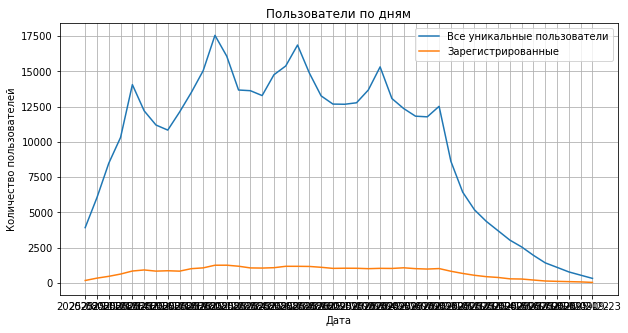

In [6]:
plt.figure(figsize=(10,5))

plt.plot(daily_uniq_users.index, daily_uniq_users.values, label='Все уникальные пользователи')
plt.plot(daily_reg_users.index, daily_reg_users.values, label='Зарегистрированные')

plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Пользователи по дням')
plt.legend()
plt.grid(True)
plt.show()

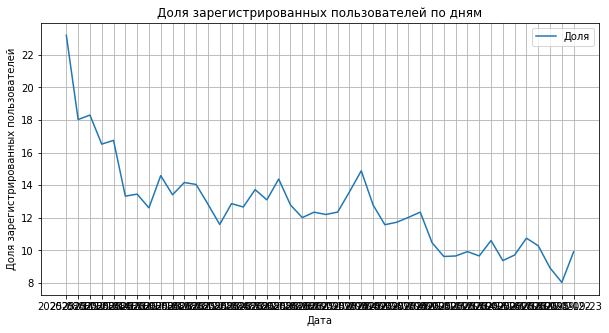

In [7]:
daily_users_dola = daily_uniq_users/daily_reg_users
plt.figure(figsize=(10,5))

plt.plot(daily_users_dola.index, daily_users_dola.values, label='Доля')


plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.title('Доля зарегистрированных пользователей по дням')
plt.legend()
plt.grid(True)
plt.show()

#### 1.4. Анализ числа просмотренных страниц

In [8]:
session_page_counter = (
    sessions_history.groupby('page_counter')['session_id']
    .nunique()
)
display(session_page_counter)

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

<AxesSubplot:title={'center':'число просмотренных страниц в приложении'}, xlabel='число просмотренных страниц', ylabel='количество сессий'>

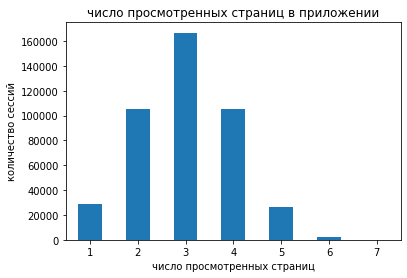

In [9]:
session_page_counter.plot(
    kind='bar',
    title='число просмотренных страниц в приложении',
    ylabel='количество сессий',
    xlabel='число просмотренных страниц',
    rot='0'
)

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

In [10]:
sessions_history['good_session'] = (sessions_history['page_counter']>=4).astype(int)

In [11]:
session_good_session = (
    sessions_history.groupby('session_date')['good_session']
    .sum()
)
session_all_session = (
    sessions_history.groupby('session_date')['good_session']
    .count()
)

dola_good_session = session_good_session/session_all_session
display(dola_good_session)

session_date
2025-08-11    0.312835
2025-08-12    0.302015
2025-08-13    0.306750
2025-08-14    0.316055
2025-08-15    0.304941
2025-08-16    0.306186
2025-08-17    0.317589
2025-08-18    0.310545
2025-08-19    0.312840
2025-08-20    0.306941
2025-08-21    0.303169
2025-08-22    0.313158
2025-08-23    0.302077
2025-08-24    0.309800
2025-08-25    0.305464
2025-08-26    0.310934
2025-08-27    0.311120
2025-08-28    0.310567
2025-08-29    0.313104
2025-08-30    0.313814
2025-08-31    0.302503
2025-09-01    0.312495
2025-09-02    0.315499
2025-09-03    0.304140
2025-09-04    0.315501
2025-09-05    0.303837
2025-09-06    0.304557
2025-09-07    0.312121
2025-09-08    0.308811
2025-09-09    0.305518
2025-09-10    0.305125
2025-09-11    0.304650
2025-09-12    0.301585
2025-09-13    0.299055
2025-09-14    0.307745
2025-09-15    0.305841
2025-09-16    0.312005
2025-09-17    0.320251
2025-09-18    0.292520
2025-09-19    0.318054
2025-09-20    0.301818
2025-09-21    0.288660
2025-09-22    0.30952

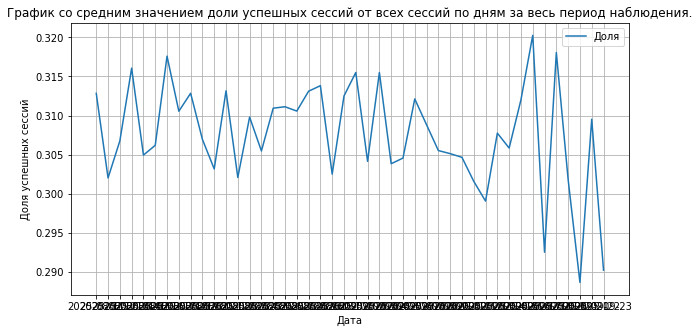

In [12]:

plt.figure(figsize=(10,5))

plt.plot(dola_good_session.index, dola_good_session.values, label='Доля')


plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.title('График со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.')
plt.legend()
plt.grid(True)
plt.show()

### 2. Подготовка к тесту

#### 2.1 Формулировка нулевой и альтернативной гипотез

С новым алгоритмом увеличится вовлеченность пользователей. А именно увеличатся случаи когда за одну сессию было просмотрено 4 и более страниц

H₀ (нулевая гипотеза):

Новый алгоритм не увеличивает долю глубоких сессий.

𝐻0:𝑝𝐵≤𝑝𝐴

H₁ (альтернативная гипотеза):

Новый алгоритм увеличивает долю глубоких сессий.

𝐻1:𝑝𝐵>𝑝𝐴

#### 2.2. Расчёт размера выборки

In [13]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize


alpha = 0.05 
beta = 0.2  
power = 1 - beta  
p1 = 0.3 
mde = 0.03 * p1  
effect_size = proportion_effectsize(p1, p1 + mde)


power_analysis = NormalIndPower()


sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста


In [14]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
daily_users = sessions_history.groupby('session_date')['user_id'].nunique()
avg_daily_users = ceil(daily_users.mean())
# Длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие метрики корректно считаются.

In [15]:
sessions_test_part=pd.read_csv('/datasets/sessions_project_test_part.csv')
display(sessions_test_part)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B
...,...,...,...,...,...,...,...,...,...,...,...
3125,02A3BA5F727BC3C9,7D4427384463A16E,2025-10-14,2025-10-14 14:52:26,2025-10-14,1,0,4,MENA,Android,B
3126,A7E51F39427F03A5,290910138655DD03,2025-10-14,2025-10-14 19:15:18,2025-10-14,1,0,2,CIS,PC,B
3127,78DDBD077D61EEDB,C10E073BFF1FAF0C,2025-10-14,2025-10-14 16:07:20,2025-10-14,1,0,2,EU,iPhone,B
3128,B44E0A30E8ED1AFC,7B404F7021711E5D,2025-10-14,2025-10-14 17:41:01,2025-10-14,1,0,3,EU,Mac,B


In [16]:

daily_users_test = sessions_test_part.groupby(['session_date','test_group'])['user_id'].nunique()
print(daily_users_test)

session_date  test_group
2025-10-14    A             1477
              B             1466
Name: user_id, dtype: int64


In [17]:
A = daily_users_test.loc[('2025-10-14', 'A')]
B = daily_users_test.loc[('2025-10-14', 'B')]

P = round(100 * abs(A - B) / A,2)
print(f"Процентная разница в количестве пользователей в группах A и B = {P}")

Процентная разница в количестве пользователей в группах A и B = 0.74


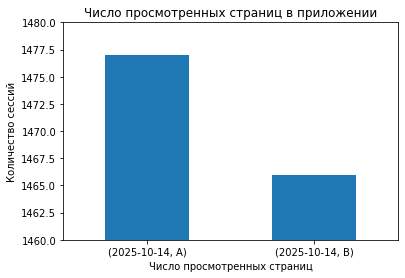

In [18]:


ax = daily_users_test.plot(
    kind='bar',
    title='Число просмотренных страниц в приложении',
    ylabel='Количество сессий',
    xlabel='Число просмотренных страниц',
    rot=0
)

ax.set_ylim(bottom=1460, top=1480) 
plt.show()


#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [19]:
daily_users_test_odnov = sessions_test_part.groupby(['test_group'])['user_id'].unique()

users_A = set(daily_users_test_odnov.loc['A'])
users_B = set(daily_users_test_odnov.loc['B'])

common = users_A & users_B
print(common)

set()


Пересечения групп нету

#### 3.3. Равномерность разделения пользователей по устройствам


In [20]:
sessions_test_part_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
sessions_test_part_B = sessions_test_part[sessions_test_part['test_group'] == 'B']

type_device_A = sessions_test_part_A.groupby('device')['user_id'].nunique()

device_share_A  = type_device_A  / type_device_A.sum() * 100


type_device_B = sessions_test_part_B.groupby('device')['user_id'].nunique()

device_share_B  = type_device_B / type_device_B.sum() * 100


print(device_share_A)
print(device_share_B)

device
Android    44.414353
Mac        10.561950
PC         24.983074
iPhone     20.040623
Name: user_id, dtype: float64
device
Android    45.566166
Mac        10.095498
PC         25.989086
iPhone     18.349250
Name: user_id, dtype: float64


<AxesSubplot:title={'center':'доля каждого типа устройства для пользователей из группы A'}>

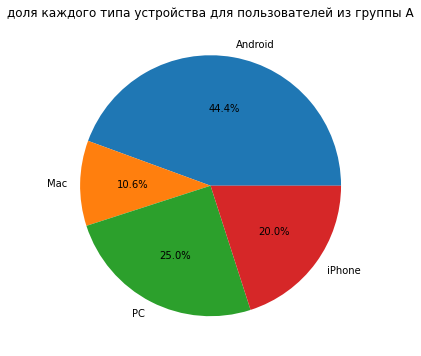

In [21]:
device_share_A.plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(6, 6),       
    title='доля каждого типа устройства для пользователей из группы A',
    ylabel=""
)

<AxesSubplot:title={'center':'доля каждого типа устройства для пользователей из группы B.'}>

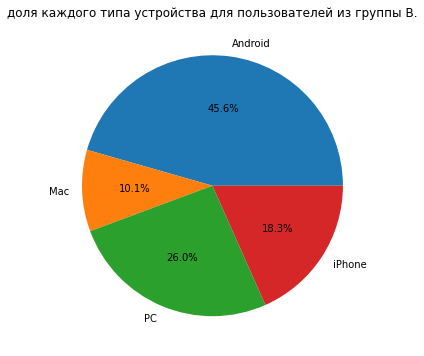

In [22]:
device_share_B.plot(
    kind='pie',
    autopct='%1.1f%%',  
    figsize=(6, 6),      
    title='доля каждого типа устройства для пользователей из группы B.', 
    ylabel=""
)

#### 3.4. Равномерность распределения пользователей по регионам

In [23]:
type_region_A = sessions_test_part_A.groupby('region')['user_id'].nunique()

region_share_A  = type_region_A  / type_region_A.sum() * 100


type_region_B = sessions_test_part_B.groupby('region')['user_id'].nunique()

region_share_B  = type_region_B / type_region_B.sum() * 100


print(region_share_A)
print(region_share_B)

region
CIS     43.601896
EU      15.165877
MENA    41.232227
Name: user_id, dtype: float64
region
CIS     43.997271
EU      14.802183
MENA    41.200546
Name: user_id, dtype: float64


<AxesSubplot:title={'center':'доля каждого региона для пользователей из группы A'}, ylabel='user_id'>

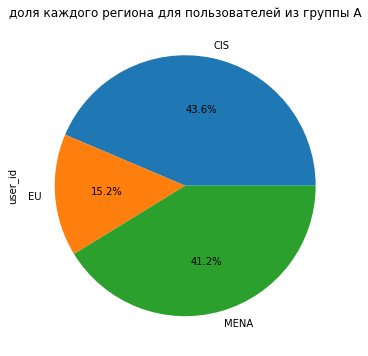

In [24]:
region_share_A.plot(
    kind='pie',
    autopct='%1.1f%%',   
    figsize=(6, 6),       
    title='доля каждого региона для пользователей из группы A'             
)

<AxesSubplot:title={'center':'доля каждого региона для пользователей из группы B'}>

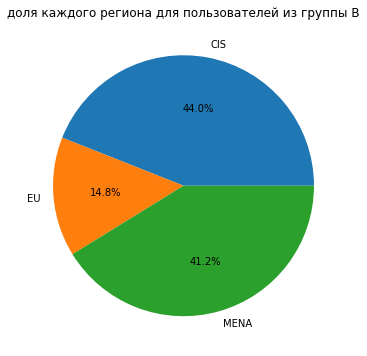

In [25]:
region_share_B.plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(6, 6),       
    title='доля каждого региона для пользователей из группы B',
    ylabel=""
)

#### 3.5. Вывод после проверки A/B-теста


Заключение:

1. Разница на 11 человек в A группе больше.
2. Являются независимыми. Пересечения не обнаружены
3. Разница есть, но не существенная.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

В дополнительный столбец `good_session` войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [26]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')
sessions_test['good_session'] = (sessions_test['page_counter']>=4).astype(int)
display(sessions_test)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1


#### 4.2. Проверка корректности результатов теста



In [27]:
sessions_test_A = sessions_test[sessions_test['test_group'] == 'A']
sessions_test_B = sessions_test[sessions_test['test_group'] == 'B']

In [28]:
users = (
    sessions_test
        .groupby(['test_group'])['user_id']
        .nunique()
)
display(users)

test_group
A    15163
B    15416
Name: user_id, dtype: int64

In [29]:
daily = (
    sessions_test
        .groupby(['session_date', 'test_group'])['session_id']
        .nunique()
        .unstack('test_group')
)

print(daily['B'] / daily['A'])


session_date
2025-10-14    1.083888
2025-10-15    1.021477
2025-10-16    0.988110
2025-10-17    0.991440
2025-10-18    1.009176
2025-10-19    1.037337
2025-10-20    1.043173
2025-10-21    1.013751
2025-10-22    1.009082
2025-10-23    1.031579
2025-10-24    0.989474
2025-10-25    0.956247
2025-10-26    1.013781
2025-10-27    1.043329
2025-10-28    1.007819
2025-10-29    1.058989
2025-10-30    0.987599
2025-10-31    1.038820
2025-11-01    1.071429
2025-11-02    1.012658
dtype: float64


In [30]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(daily['A'], daily['B'], equal_var=False)  
print(p_value)

0.9382195854082714


средние двух выборок равны.

#### 4.3. Сравнение доли успешных сессий


In [31]:
session_good_session = (
    sessions_test.groupby(['session_date', 'test_group'])['good_session']
    .sum().unstack('test_group')
)
session_all_session = (
    sessions_test.groupby(['session_date', 'test_group'])['good_session']
    .count().unstack('test_group')
)

dola_good_session = round(session_good_session/session_all_session,3)
dola_good_session['razn'] = dola_good_session['B']-dola_good_session['A']
display(dola_good_session)

test_group,A,B,razn
session_date,,,
2025-10-14,0.322,0.381,0.059
2025-10-15,0.307,0.310,0.003
2025-10-16,0.308,0.324,0.016
2025-10-17,0.307,0.318,0.011
2025-10-18,0.317,0.311,-0.006
2025-10-19,0.301,0.313,0.012
2025-10-20,0.309,0.316,0.007
2025-10-21,0.304,0.310,0.006
2025-10-22,0.313,0.322,0.009


In [32]:
print(dola_good_session['A'].mean())
print(dola_good_session['B'].mean())
print(dola_good_session['A'].mean()-dola_good_session['B'].mean())

0.30825
0.326
-0.017749999999999988


#### 4.4. Насколько статистически значимо изменение ключевой метрики


In [33]:
from statsmodels.stats.proportion import proportions_ztest
n_a = sessions_test_A['test_group'].count()
n_b = sessions_test_B['test_group'].count()
m_a = session_good_session['A'].sum()
m_b = session_good_session['B'].sum()
stat_ztest, p_value_ztest = proportions_ztest(
 [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)
print(p_value_ztest)

0.0001574739988036123


Тесты статистически значимы

#### 4.5. Вывод по результатам A/B-эксперимента


1. Характеристики эксперимента:

В тесте участвовали: 15163 пользователей в группе A и 15416 пользователей в группе B.

Длительность эксперимента: с 2025-10-14 по 2025-11-02 (20 дней).

Ключевая метрика: доля успешных сессий (good_session).

2. Изменение ключевой метрики:

Среднее значение метрики в группе A: 0.30825

Среднее значение метрики в группе B: 0.326

Абсолютная разница: Δ = -0.017749999999999988

3. Статистическая значимость:

Использованный тест: Z-test

p-value = 0.0001574739988036123

Интерпретация:

Если p-value < 0.05 → разница статистически значима.

Если p-value ≥ 0.05 → статистических оснований для внедрения нет.

4. Рекомендация:

Эффект статистически значим и положителен → можно внедрять новый алгоритм.
